In [6]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns
plt.style.use('seaborn-white')

In [7]:
log_directory = '../../../data/raw/logs/'

In [8]:
def get_log_files(dir_path, pattern):
    result = []
    for filename in os.listdir(dir_path):
        res = re.search(pattern, filename)
        if res:
            data_size = res.group(1)
            segment_count = res.group(2)
            rate_limit = res.group(3)
            if data_size:
                result.append((data_size, segment_count, rate_limit, dir_path + "/" + filename))
    return result

In [34]:
def get_kafka_files(dir_path, pattern):
    result = []
    for filename in os.listdir(dir_path):
        res = re.search(pattern, filename)
        if res:
            data_size = res.group(1)
            rate_limit = res.group(2)
            if data_size:
                result.append((data_size, rate_limit, dir_path + "/" + filename))
    return result

In [9]:
def get_consumer_files(dir_path, pattern):
    result = []
    for filename in os.listdir(dir_path):
        res = re.search(pattern, filename)
        if res:
            data_size = res.group(1)
            if data_size:
                result.append((data_size, dir_path + "/" + filename))
    return result

# Maximum Producer Throughput

In [38]:
def get_kafka_producer_throughput_files():
    return get_kafka_files(log_directory + "20200602/throughput", "kafka_producer_(\d+)_(\d+)_throughput.csv")

In [10]:
def get_exclusive_producer_throughput_files():
    return get_log_files(log_directory + "20200719/throughput/exclusive", "rembrandt_producer_(\d+)_(\d+)_(\d+)_throughput.csv")
def get_exclusive_opt_producer_throughput_files():
    return get_log_files(log_directory + "20200719/throughput/exclusive_opt", "rembrandt_producer_(\d+)_(\d+)_(\d+)_throughput.csv")
def get_concurrent_producer_throughput_files():
    return get_log_files(log_directory + "20200724/throughput/concurrent", "rembrandt_producer_(\d+)_(\d+)_(\d+)_throughput.csv")
def get_concurrent_opt_producer_throughput_files():
    return get_log_files(log_directory + "20200724/throughput/concurrent_opt/10", "rembrandt_producer_(\d+)_(\d+)_(\d+)_throughput.csv")

In [48]:
def get_kafka_consumer_throughput_files():
    return get_kafka_files(log_directory + "20200602/throughput", "kafka_consumer_(\d+)_(\d+)_throughput.csv")

In [22]:
def get_exclusive_consumer_throughput_files():
    return get_consumer_files(log_directory + "20200719/throughput/exclusive", "rembrandt_consumer_(\d+)_throughput.csv")
def get_exclusive_opt_consumer_throughput_files():
    return get_consumer_files(log_directory + "20200719/throughput/exclusive_opt", "rembrandt_consumer_(\d+)_throughput.csv")
def get_concurrent_consumer_throughput_files():
    return get_consumer_files(log_directory + "20200724/throughput/concurrent", "rembrandt_consumer_(\d+)_throughput.csv")
def get_concurrent_opt_consumer_throughput_files():
    return get_consumer_files(log_directory + "20200724/throughput/concurrent_opt/10", "rembrandt_consumer_(\d+)_throughput.csv")

In [4]:
def create_rembrandt_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, segment_count, rate_limit, filename in log_files:
        df  = pd.read_csv(filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size in Bytes"] = int(data_size)
        df["# of Segments"] = int(segment_count)
        df["Rate Limit in MB/s"] = int(rate_limit) // (1000 * 1000)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [41]:
def create_kafka_producer_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, rate_limit, filename in log_files:
        df  = pd.read_csv(filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size in Bytes"] = int(data_size)
        df["Rate Limit in MB/s"] = int(rate_limit) // (1000 * 1000)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [42]:
kafka_producer_log_files = get_kafka_producer_throughput_files()
kafka_producer_df = create_kafka_producer_dataframe(kafka_producer_log_files)
kafka_producer_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size in Bytes,Rate Limit in MB/s
0,0,3243,212.533,65536,1000
1,1,3315,217.252,65536,1000
2,2,3223,211.223,65536,1000
3,3,2829,185.401,65536,1000
4,4,2859,187.367,65536,1000


In [11]:
exclusive_producer_log_files = get_exclusive_producer_throughput_files()
exclusive_producer_df = create_rembrandt_dataframe(exclusive_producer_log_files)
exclusive_producer_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size in Bytes,# of Segments,Rate Limit in MB/s
0,0,58175,953.139,16384,1,15000
1,1,58053,951.140,16384,1,15000
2,2,58934,965.575,16384,1,15000
3,3,58866,964.461,16384,1,15000
4,4,57937,949.240,16384,1,15000


In [12]:
exclusive_opt_producer_log_files = get_exclusive_opt_producer_throughput_files()
exclusive_opt_producer_df = create_rembrandt_dataframe(exclusive_opt_producer_log_files)
exclusive_opt_producer_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size in Bytes,# of Segments,Rate Limit in MB/s
0,0,70274,1151.369,16384,1,15000
1,1,70968,1162.740,16384,1,15000
2,2,70657,1157.644,16384,1,15000
3,3,70343,1152.500,16384,1,15000
4,4,70237,1150.763,16384,1,15000


In [15]:
concurrent_producer_log_files = get_concurrent_producer_throughput_files()
concurrent_producer_df = create_rembrandt_dataframe(concurrent_producer_log_files)
concurrent_producer_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size in Bytes,# of Segments,Rate Limit in MB/s
0,0,50572,828.572,16384,90,15000
1,1,51046,836.338,16384,90,15000
2,2,51038,836.207,16384,90,15000
3,3,51045,836.321,16384,90,15000
4,4,50221,822.821,16384,90,15000


In [13]:
concurrent_opt_producer_log_files = get_concurrent_opt_producer_throughput_files()
concurrent_opt_producer_df = create_rembrandt_dataframe(concurrent_opt_producer_log_files)
concurrent_opt_producer_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size in Bytes,# of Segments,Rate Limit in MB/s
0,0,70166,1149.600,16384,90,15000
1,1,70906,1161.724,16384,90,15000
2,2,71095,1164.820,16384,90,15000
3,3,68983,1130.217,16384,90,15000
4,4,68926,1129.284,16384,90,15000


In [16]:
def plot_histogram(dataframe):
#     fig_dims = (18, 12)
    fig, ax = plt.subplots()
#     sns.set(font_scale=2)
    sns.set_context('poster')
    sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
    sns.despine(left=True)
    g = sns.lineplot(x="Message Size in Bytes", y="Throughput in MB/s", data=dataframe, ax=ax,ci="sd")
    g.set_xlabel("Message Size")
    ax.set_xscale('log')
    g.set_xticks([8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608])
    g.set_xticklabels(['8K','16K','32K','64K','128K','256K','512K','1M', '2M', '4M', '8M'])
    plt.xticks(fontsize=20, rotation=45)
    plt.yticks(fontsize=20)

In [18]:
def plot_comp_histogram(dataframes, measure, filename):
#     df = pd.DataFrame()
    for label, dataframe in dataframes.items():
        dataframe["Broker"] = label
    df = pd.concat(dataframes.values())
    fig, ax = plt.subplots()
    sns.set_context('paper')
    sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
    sns.despine(left=True)
    g = sns.lineplot(x="Message Size in Bytes", y=measure, hue="Broker", data=df, ax=ax,ci="sd")
    g.set_xlabel("Message Size")
    g.set_ylabel("Avg. " + measure)
    ax.set_xscale('log')
    g.set_xticks([8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608])
    g.set_xticklabels(['8K','16K','32K','64K','128K','256K','512K','1M', '2M', '4M', '8M'])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])
    plt.xticks(rotation=45)
#     plt.yticks(fontsize=20)
    fig.savefig(filename, bbox_inches="tight", dpi=600)

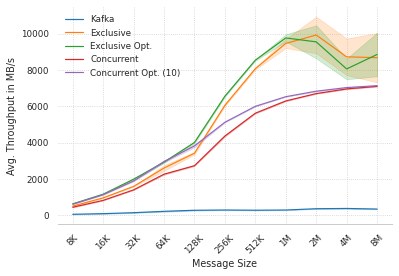

In [47]:
producer_dfs = {"Kafka": kafka_producer_df, "Exclusive": exclusive_producer_df, "Exclusive Opt.": exclusive_opt_producer_df, "Concurrent": concurrent_producer_df, "Concurrent Opt. (10)": concurrent_opt_producer_df}
plot_comp_histogram(producer_dfs, "Throughput in MB/s","ghostwriter_producer_throughput")

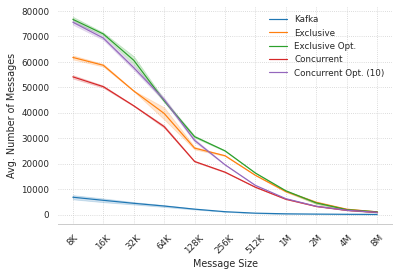

In [46]:
plot_comp_histogram(producer_dfs, "Number of Messages","ghostwriter_producer_message_rate")

In [52]:
def create_kafka_consumer_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, rate_limit, filename in log_files:
        df  = pd.read_csv(filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size in Bytes"] = int(data_size)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [53]:
def create_rembrandt_consumer_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, filename in log_files:
        df  = pd.read_csv(filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size in Bytes"] = int(data_size)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [54]:
kafka_consumer_log_files = get_kafka_consumer_throughput_files()
kafka_consumer_df = create_kafka_consumer_dataframe(kafka_consumer_log_files)
kafka_consumer_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size in Bytes
0,0,2320,38.011,16384
1,1,2431,39.830,16384
2,2,3511,57.524,16384
3,3,3403,55.755,16384
4,4,3436,56.295,16384


In [25]:
exclusive_consumer_log_files = get_exclusive_consumer_throughput_files()
exclusive_consumer_df = create_rembrandt_consumer_dataframe(exclusive_consumer_log_files)
exclusive_consumer_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size in Bytes
0,0,2767,11605.639,4194304
1,1,2768,11609.833,4194304
2,2,2767,11605.639,4194304
3,3,2768,11609.833,4194304
4,4,2766,11601.445,4194304


In [26]:
exclusive_opt_consumer_log_files = get_exclusive_opt_consumer_throughput_files()
exclusive_opt_consumer_df = create_rembrandt_consumer_dataframe(exclusive_opt_consumer_log_files)
exclusive_opt_consumer_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size in Bytes
0,0,2796,11727.274,4194304
1,1,2796,11727.274,4194304
2,2,2796,11727.274,4194304
3,3,2796,11727.274,4194304
4,4,2796,11727.274,4194304


In [27]:
concurrent_consumer_log_files = get_concurrent_consumer_throughput_files()
concurrent_consumer_df = create_rembrandt_consumer_dataframe(concurrent_consumer_log_files)
concurrent_consumer_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size in Bytes
0,0,2648,11106.517,4194304
1,1,2648,11106.517,4194304
2,2,2647,11102.323,4194304
3,3,2648,11106.517,4194304
4,4,2647,11102.323,4194304


In [28]:
concurrent_opt_consumer_log_files = get_concurrent_opt_consumer_throughput_files()
concurrent_opt_consumer_df = create_rembrandt_consumer_dataframe(concurrent_opt_consumer_log_files)
concurrent_opt_consumer_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size in Bytes
0,0,2676,11223.958,4194304
1,1,2676,11223.958,4194304
2,2,2675,11219.763,4194304
3,3,2676,11223.958,4194304
4,4,2675,11219.763,4194304


In [56]:
consumer_dfs = {"Kafka": kafka_consumer_df, "Exclusive": exclusive_consumer_df, "Exclusive Opt.": exclusive_opt_consumer_df, "Concurrent": concurrent_consumer_df, "Concurrent Opt. (10)": concurrent_opt_consumer_df}

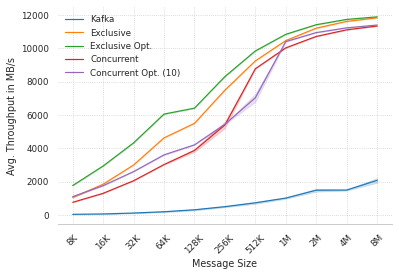

In [59]:
plot_comp_histogram(consumer_dfs, "Throughput in MB/s","ghostwriter_consumer_throughput")

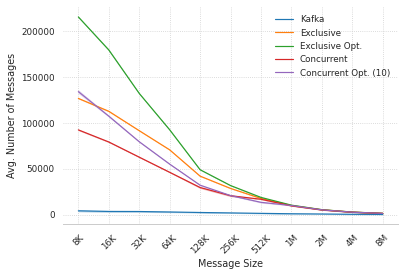

In [60]:
plot_comp_histogram(consumer_dfs, "Number of Messages","ghostwriter_consumer_message_rate")